# Ancient Chinese Art DCGAN

This notebook trains a DCGAN to generate 64px images of ancient Chinese art. If you want to try the model with the parameters in the Github repo, scroll to the bottom of this notebook. If you want to try re-training the entire model, follow these steps:

1. Download the dataset from the Github repo.
2. Upload this dataset to your Jupyter notebook. 
3. Run all the cells below in order. The comments in each cell give an overivew of what the function of the code is. 

If you want to try the model with the model parameters provided in the Github repo, run all the cells until the next text cell. Follow the instructions in that cell to load in model parameters. **Avoid any errors that pop up; they will not affect the process of loading in parameters.**


In [ ]:
%matplotlib inline

In [ ]:

#import necessary libraries
import argparse
import random
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# create a folder to load data into

import os

# define the name of the directory to be created
path = "images"

try:
    os.mkdir(path)     # creates the directory to store extracted images
# raises an error if the directory is not detected
except OSError: 
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Successfully created the directory images 


In [ ]:
# load in necessary data
import zipfile
with zipfile.ZipFile('real_data.zip', 'r') as zip_ref:    # use this dir for large dataset: 'drive/MyDrive/archive (1).zip'
    zip_ref.extractall('images')    # loads all images into the images folder created above

FileNotFoundError: ignored

In [ ]:
# define variables needed to train the net
# DEFINE NEW HYPERPARAMETERS HERE!!

batch_size = 64  # how many examples the model trains on per time
img_size = 64   # size of each inputted image
n_channels = 3  # RGB images have three colors, so they have 3 channels
n_z = 100      # size of latent Z vector used to generate images
n_generator = 64  # size of generator's feature map
n_discriminator = 64    # size of discriminator's feature map
n_epochs = 300        # how many times the model will go thru training set
lr_gen = 0.0002          # pre-defined by DCGAN paper
lr_dis = 0.00005
beta1 = 0.5          # pre-defined by DCGAN paper
ngpu = 1             # number of GPUs available for training

In [ ]:
# run on GPU to train faster, if GPU isn't available use CPU instead
device = torch.device('cuda:0' if(torch.cuda.is_available() and ngpu > 0) else 'cpu')

In [ ]:

# load data into a PyTorch dataloader

# create the dataset using the PyTorch image folder, which reads in images from a folder
# input the root directory, and a set of transforms. These transforms resize and crop the images
# to the necessary size to be fed into the DCGAN, which is, in this case, a 64x64 image. 
# Data is then converted into a PyTorch tensor and normalized with the values given in the 
# DCGAN paper. 
data = dset.ImageFolder(root='images', transform=transforms.Compose([transforms.Resize(img_size),
                                                                       transforms.CenterCrop(img_size),
                                                                       transforms.RandomHorizontalFlip(p=0.5),
                                                                       transforms.ToTensor(),
                                                                       transforms.Normalize((0.5, 0.5, 0.5), 
                                                                                            (0.5, 0.5, 0.5)),]))

# create the PyTorch dataloader, specify the data used, the batch size, and ensure
# to shuffle the data
dataloader = torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle=True)

# visualize data
batch = next(iter(dataloader))    # get batch from dataloader
plt.axis('off')
plt.title('Training Data')
plt.figure(figsize=(12,12))         # create a figure to visualize images
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device),      # display data in grid
                                         padding=2, normalize=True).cpu(),(1,2,0)))

RuntimeError: ignored

In [ ]:
#############################################
###             DCGAN CODE                ###
#############################################

In [ ]:
# initializes all weights to come from a normal distribution w/given parameters
# given parameters were specified in the DCGAN paper
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant(m.bias.data, 0)

In [ ]:
# creating the generator

class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # can calculate ConvTranspose shaps using below formula:
        # (i - 1) * s + k - 2p, where:
        # i = input, s = stride, k = kernel_size, and p = padding

        # Z latent features vector passes into first Conv layer
        nn.ConvTranspose2d(n_z, n_generator * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(n_generator * 8),
        nn.ReLU(True),
        # current shape: (n_generator*8 x 4 x 4)
        nn.ConvTranspose2d(n_generator*8, n_generator*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_generator*4),
        nn.ReLU(True),
        # current shape: (n_generator*4 x 8 x 8)
        nn.ConvTranspose2d(n_generator*4, n_generator*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_generator*2),
        nn.ReLU(True),
        # current shape: (n_generator*2 x 16 x 16)
        nn.ConvTranspose2d(n_generator*2, n_generator, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_generator),
        nn.ReLU(True),
        # current shape: (n_generator x 32 x 32)
        nn.ConvTranspose2d(n_generator, n_channels, 4, 2, 1, bias=False),
        nn.Tanh()
        # current shape: (n_channels x 64 x 64)
        # this is the same shape as the necessary input image, which 
        # is the necessary shape for the generator to create images
    )
  
  def forward(self, x):
    return self.main(x)

In [ ]:
gen = Generator(ngpu).to(device)    # create model instance
gen.apply(weights_init)      # after instantiating model, assign custom weights
print(gen)    # print out model details

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  if __name__ == '__main__':


In [ ]:
# discriminator code

# discriminator shapes should be the opposite of the generator,
# as generator was upsampling and discriminator is downsampling

class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # calculate shape of each layer with this formula:
        # ((i - k + 2p) / s) + 1
        # where i = input, k = kernel size, p = padding, s= stride

        # takes in an input image, so img shape is (3 x 64 x 64)
        nn.Conv2d(n_channels, n_discriminator, 4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        # current shape: (n_generator x 32 x 32)
        nn.Conv2d(n_discriminator, n_discriminator*2, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(n_discriminator*2),
        nn.LeakyReLU(0.2, inplace=True),

        # current shape: (n_generator*2 x 16 x 16)
        nn.Conv2d(n_discriminator*2, n_discriminator*4, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(n_discriminator*4),
        nn.LeakyReLU(0.2, inplace=True),

        # current shape: (n_generator*4 x 8 x 8)
        nn.Conv2d(n_discriminator*4, n_discriminator*8, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(n_discriminator*8),
        nn.LeakyReLU(0.2, inplace=True),

        # current shape: (n_generator*8 x 4 x 4)
        nn.Conv2d(n_discriminator*8, 1, 4, stride=1, padding=0, bias=False),
        nn.Sigmoid()

        # the discriminator only returns 1 value, which corresponds
        # to the probability that an image is either real 
        # or fake
    )
  def forward(self, x):
    return self.main(x)

In [ ]:
dis = Discriminator(ngpu).to(device)  # send to GPU and instantiate model
dis.apply(weights_init)     # apply custom weights
print(dis)    # print model

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  if __name__ == '__main__':


## If you want to try the existing model parameters, stop here. 

Scroll past the cells below to the next text cell to load in model parameters and create new images.

In [ ]:
# creating the optimizers and loss function
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, n_z, 1, 1, device=device)

# values to be used for real and fake labels in the training loop
real_label = 1
fake_label = 0

# use Adam for both generator and discriminator
optimGen = optim.Adam(gen.parameters(), lr=lr_gen, betas=(beta1, 0.999))
optimDis = optim.Adam(dis.parameters(), lr=lr_dis, betas=(beta1, 0.999))

In [ ]:
# store loss values in an array to graph
# MODEL TRAINS HERE

img_list = []
generator_losses = []
discriminator_losses = []

for epoch in range(n_epochs):

  # iterates over dataloader, gets one batch at a time
  for i, data in enumerate(dataloader, 0):

    #updating discriminator
    dis.zero_grad()

    #format the batch
    # all the data passed in below is real
    data_todevice = data[0].to(device)
    batch_size = data_todevice.size(0)    # grab batch size from the moved data
    label = torch.full((batch_size,), real_label, dtype = torch.float, device=device)  # creates an array full of ones

    out = dis(data_todevice).view(-1)    # send data to discriminator
    dis_err_real = criterion(out, label)  # find error in discriminator
    dis_err_real.backward()   # backpropogate
    D_x = out.mean().item()    # store in this to pass into discriminator losses array

    # now train with the fake data
    # first create a random z vector
    random_z = torch.randn(batch_size, n_z, 1, 1, device=device)
    #create some fake images by passing this z into generator
    fake_images = gen(random_z)
    label.fill_(fake_label)  # replace all images in label tensor with the fake label
    out = dis(fake_images.detach()).view(-1)  # run fake images through discriminator (.detach makes it require no gradient)
    dis_err_fake = criterion(out, label)    # find loss between discriminator output and generators
    dis_err_fake.backward()   # backpropogate
    D_G_z1 = out.mean().item()

    # sum up errors from real and fake examples, update parameters for discriminator
    dis_error = dis_err_real + dis_err_fake
    optimDis.step()

    # now update the generator
    gen.zero_grad()
    label.fill_(real_label) # fill label with real labels
    out = dis(fake_images).view(-1) # pass fake images through discriminator
    gen_error = criterion(out, label)
    # above steps are done because the fake image should trick the discriminator into 
    # thinking that it is a real image. Thus, the wanted label for the generator's synthesized
    # image should be 1.
    gen_error.backward()
    D_G_z2 = out.mean().item()

    optimGen.step() # update parameters of generator

    # now print training progress every 50 iterations
    if i % 50 == 0:
      # some text formatting:
      # %d is digit characters, /t is a tab, and %.4f is a float to the fourth decimal place
      # vars are inserted at each percentage in the given order
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' 
            % (epoch, n_epochs, i, len(dataloader), dis_error.item(), gen_error.item(), D_x, D_G_z1, D_G_z2))
    generator_losses.append(gen_error.item())
    discriminator_losses.append(dis_error.item())

    # test on randomly generated noise created at the start
    if (i % 500 == 0) or ((epoch == n_epochs-1) and i==len(dataloader)-1):
      # disable gradient 
      with torch.no_grad():
        fake_image = gen(fixed_noise).detach().cpu()  # send the z vector through generator
      img_list.append(vutils.make_grid(fake_image, padding=2, normalize=True))  # append to the image list
    i += 1

[0/300][0/91]	Loss_D: 1.7380	Loss_G: 1.5974	D(x): 0.5151	D(G(z)): 0.5646 / 0.2511
[0/300][50/91]	Loss_D: 6.6373	Loss_G: 2.2376	D(x): 0.2667	D(G(z)): 0.9882 / 0.1250
[1/300][0/91]	Loss_D: 2.9958	Loss_G: 4.3220	D(x): 0.4314	D(G(z)): 0.7909 / 0.0148
[1/300][50/91]	Loss_D: 2.4895	Loss_G: 4.4195	D(x): 0.3765	D(G(z)): 0.6267 / 0.0132
[2/300][0/91]	Loss_D: 2.3504	Loss_G: 2.9391	D(x): 0.3269	D(G(z)): 0.5272 / 0.0551
[2/300][50/91]	Loss_D: 1.5236	Loss_G: 3.4866	D(x): 0.5427	D(G(z)): 0.3877 / 0.0321
[3/300][0/91]	Loss_D: 1.2193	Loss_G: 4.1665	D(x): 0.6471	D(G(z)): 0.3958 / 0.0171
[3/300][50/91]	Loss_D: 1.7336	Loss_G: 3.2083	D(x): 0.4843	D(G(z)): 0.3862 / 0.0414
[4/300][0/91]	Loss_D: 0.9307	Loss_G: 3.0469	D(x): 0.7051	D(G(z)): 0.2748 / 0.0535
[4/300][50/91]	Loss_D: 0.9441	Loss_G: 2.0116	D(x): 0.6416	D(G(z)): 0.2968 / 0.1716
[5/300][0/91]	Loss_D: 1.6068	Loss_G: 1.0617	D(x): 0.4514	D(G(z)): 0.4564 / 0.3668
[5/300][50/91]	Loss_D: 1.8476	Loss_G: 0.7855	D(x): 0.4362	D(G(z)): 0.5906 / 0.4672
[6/300][0/

In [ ]:
# save the parameters after training
torch.save(gen.state_dict(), 'van-gogh-gen-64')
torch.save(dis.state_dict(), 'van-gogh-dis-64')

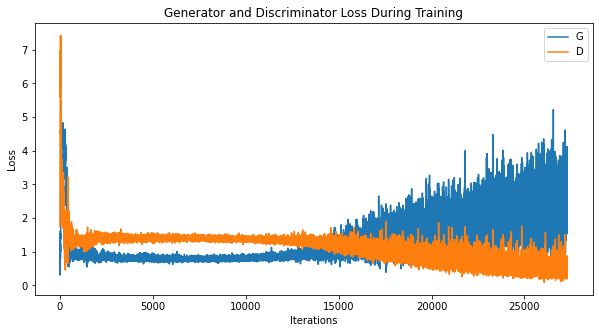

In [ ]:
# plot the losses after training
plt.figure(figsize=(10,5))
plt.title('Generator and Discriminator Loss During Training')
plt.plot(generator_losses, label='G')
plt.plot(discriminator_losses, label='D')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


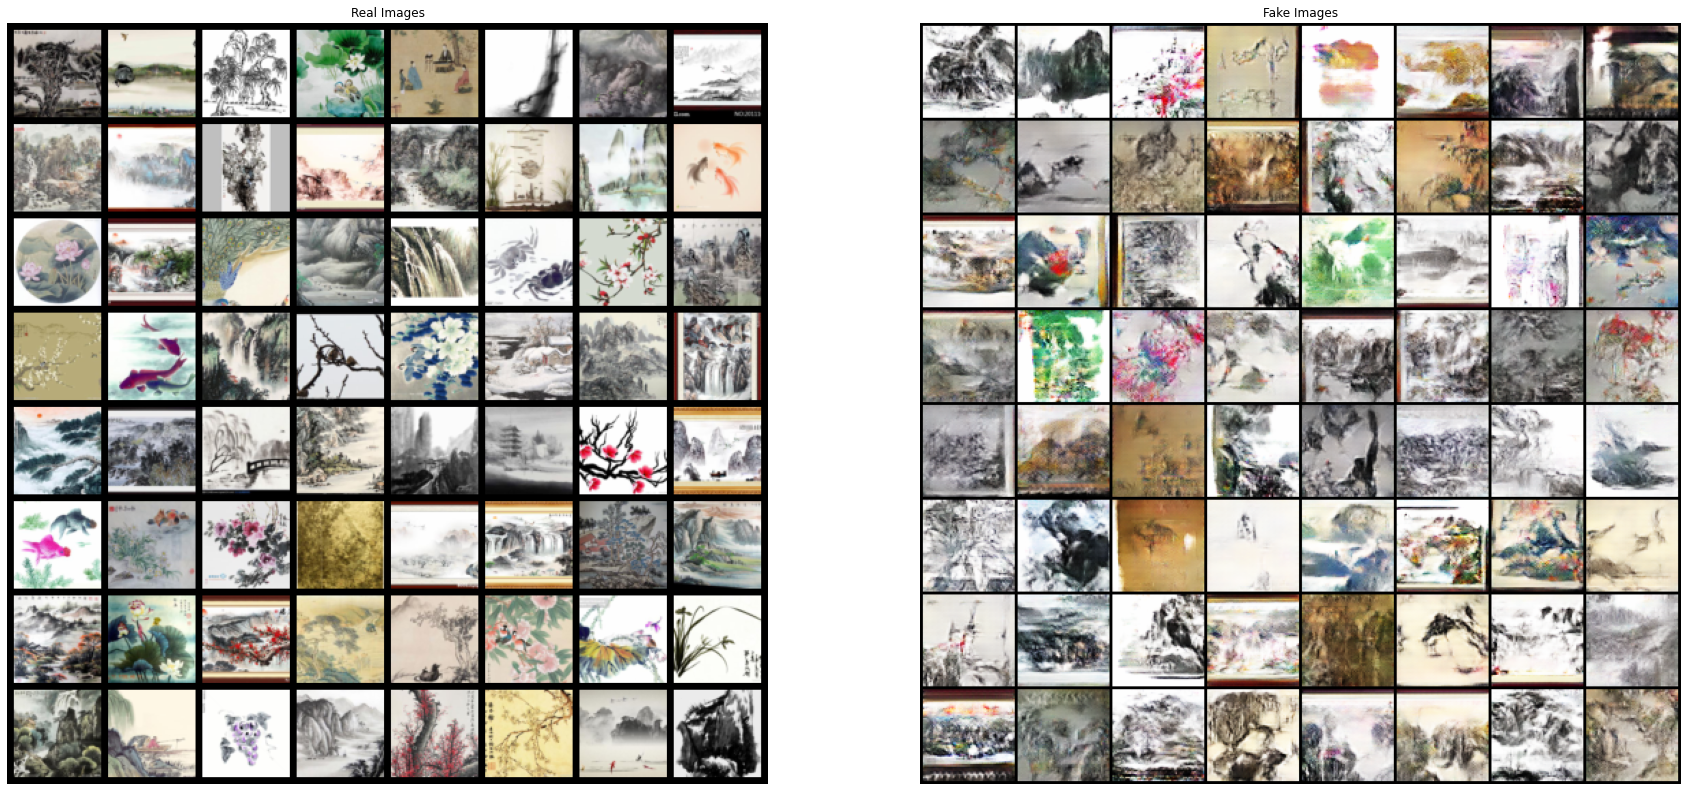

In [ ]:
# try generating some images
real_batch = next(iter(dataloader))

#plot images
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Real Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=5, normalize=True).cpu(), (1,2,0)))

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Fake Images')
plt.imshow(np.transpose(img_list[-1], (1,2,0)))
plt.show()

KeyboardInterrupt: ignored

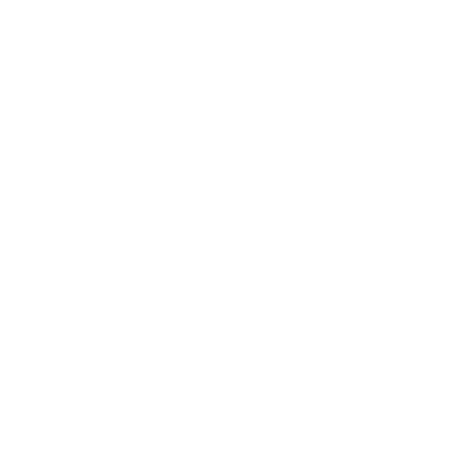

In [ ]:
# generates an animation of training progress

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Generating Your Own Examples!

This part of the notebook is for loading in existing parameters. To do this, follow these steps:

1. Download the model parameters from the Github repo. 
2. Upload them into your Jupyter notebook. 
3. Run the cells below in order.

Doing this will give you a set of 64 generated images in a grid. Enjoy! 

In [ ]:
# load in model parameters

# first re-instantiate models, move to cpu
dis = Discriminator(ngpu).to('cpu')
gen = Generator(ngpu).to('cpu')

# load in the state dicts
gen.load_state_dict(torch.load('van-gogh-gen-64', map_location=torch.device('cpu')))
dis.load_state_dict(torch.load('van-gogh-dis-64', map_location=torch.device('cpu')))

# set to evaluation mode to turn off batch norm layers
gen.eval()
dis.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

Random Seed:  7946


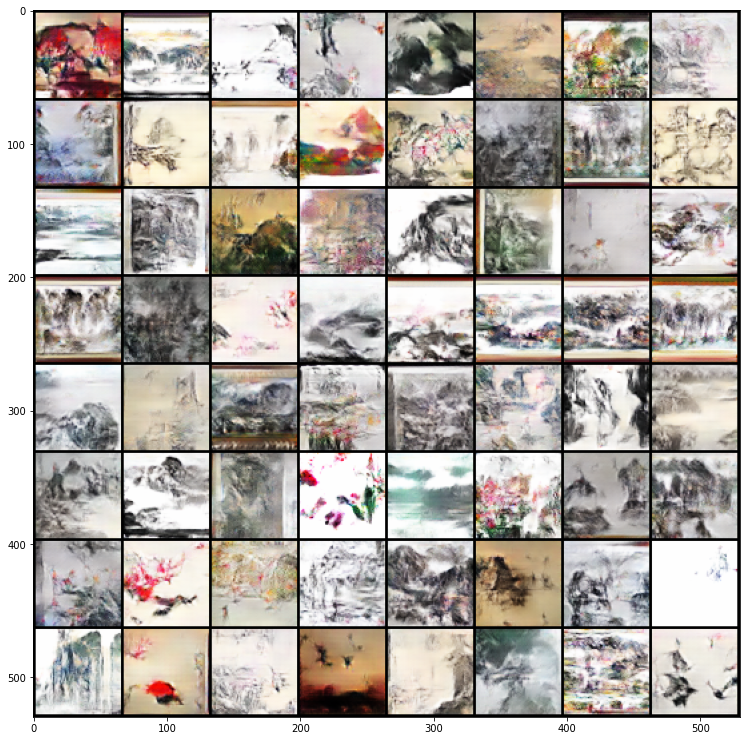

In [ ]:
# generating new images

# sets a random seed
manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

fake = gen(torch.randn(64, n_z, 1, 1, device='cpu')).detach()
plt.figure(figsize=(13, 13))
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1,2,0)))